In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    datasets,
)
import pickle
import tensorflow.keras.backend as K
import tensorboard as tb
from model_continuous import GAN
import librosa as lb
from preprocess import load_raw_audio
from preprocess import denormalise
from IPython.lib.display import Audio
import IPython
import pandas as pd
import json

In [3]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

model_directory ="C:/Users/Jayde/Desktop/wavegan/models_0212.1457"
model_directory = newest("C:/Users/Jayde/Desktop/wavegan/")
print(model_directory)
spec_path = f"{model_directory}/model_specifications.json"
with open(spec_path, 'r') as f:
  specs = json.load(f)

C:/Users/Jayde/Desktop/wavegan/models_0312.1304


In [4]:
gan = GAN(
    latent_dim = specs["Latent Dim"],
    discriminator_steps= specs["Discriminator Steps"],
    gp_weight= specs["GP Weight"],
    n_categories= specs["N Categories"],
    n_cont= specs["N Continuous"]
)

In [5]:
generator = gan.generator
generator.load_weights(f"{model_directory}/generator")

In [8]:
def create_cat_inputs(specs, size_per_cat, con_type = "zero"):
    latent_dim = specs["Latent Dim"]
    n_cat = specs["N Categories"]
    n_con = specs["N Continuous"]
    z_dim = latent_dim-n_cat-n_con
    size = size_per_cat*n_cat
    z= tf.random.normal(shape=(size, z_dim))
    
    con = tf.zeros(shape=(size, n_con)) if con_type == "zero" else tf.random.normal(shape=(size, n_con))
    cat = np.zeros(shape=(size, n_cat))
    idxs = []
    for i in range(n_cat):
        idx = [i]*size_per_cat
        idxs += idx
    cat[np.arange(size),idxs] = 1
    cat = tf.convert_to_tensor(cat, dtype=tf.float32)
    inputs = tf.concat([z,con, cat], axis=1)
    inputs = tf.split(inputs, n_cat, axis=0)
    return inputs

In [9]:
inputs = create_cat_inputs(specs,size_per_cat=10, con_type = "zero")
outputs=[]
for input in inputs:
    generated_audio = generator.predict(input) 
    generated_audio= np.squeeze(generated_audio)
    #print(generated_audio.shape)
    audio = denormalise(generated_audio,f"{model_directory}/normaliser_values")
    outputs.append(audio)


1/1 [==============================] - 2s 2s/step
DENORMALISING- MEAN:-0.00025890590040944517, STD_DEV:0.08102027326822281
DENORMALISED
1/1 [==============================] - 1s 705ms/step
DENORMALISING- MEAN:-0.00025890590040944517, STD_DEV:0.08102027326822281
DENORMALISED
1/1 [==============================] - 1s 666ms/step
DENORMALISING- MEAN:-0.00025890590040944517, STD_DEV:0.08102027326822281
DENORMALISED
1/1 [==============================] - 1s 674ms/step
DENORMALISING- MEAN:-0.00025890590040944517, STD_DEV:0.08102027326822281
DENORMALISED
1/1 [==============================] - 1s 654ms/step
DENORMALISING- MEAN:-0.00025890590040944517, STD_DEV:0.08102027326822281
DENORMALISED


In [12]:
code_1 = outputs[1]
sr = 16000
for audio in code_1:
    IPython.display.display(Audio(audio, rate =sr))

Text(117.09722222222221, 0.5, 'Amplitude')

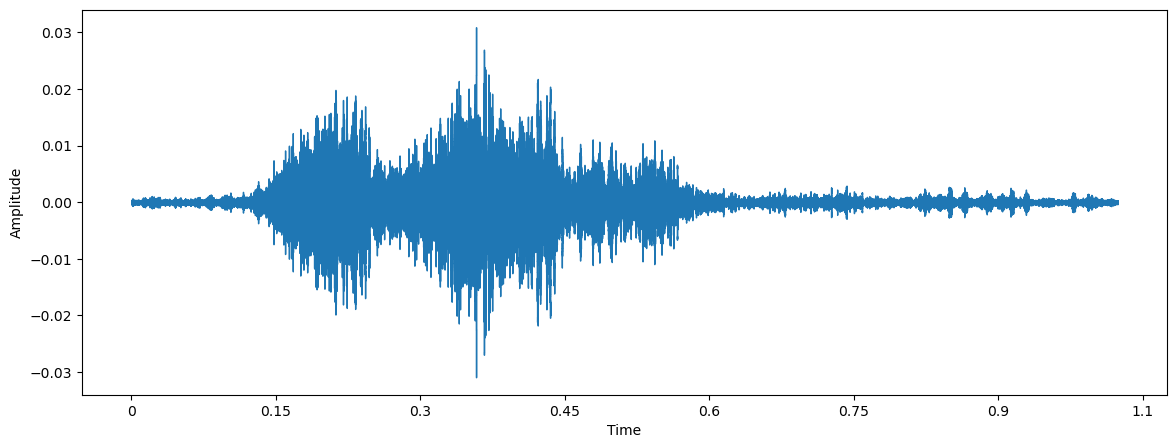

In [13]:
import librosa.display

plt.figure(figsize=(14, 5))
#plotting the sampled signal
librosa.display.waveshow(code_1[2], sr=sr)
plt.ylabel("Amplitude")

In [ ]:
from scipy.io.wavfile import write
write("example_audio4.wav", sr, audio_1)

In [14]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [14]:
event_file = os.listdir(f"{model_directory}/logs/train")[0]
event_file = f"{model_directory}/logs/train/{event_file}"

In [15]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import struct
g_loss=[]
d_loss =[]
d_gp=[]
d_w_loss=[]
q_loss =[]
steps=[]
for e in summary_iterator(event_file):    
    for v in e.summary.value:
        if v.tag == 'epoch_g_loss':            
            g_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_d_loss':            
            d_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_d_gp':            
            d_gp.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_d_wass_loss':            
            d_w_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_q_loss':            
            q_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [40]:
lr = specs["Learning Rate"]
specs_str = '\n'.join((
    r'Batch Size = %.f' % (specs["Batch Size"], ),
    r'Training Size = %.f' % (specs["Training Size"],),
    r'Discriminator Steps = %.f' % (specs["Discriminator Steps"], ),
    f"Learning Rate = {lr}"))
specs_str

'Batch Size = 64\nTraining Size = 640\nDiscriminator Steps = 3\nLearning Rate = 1e-05'

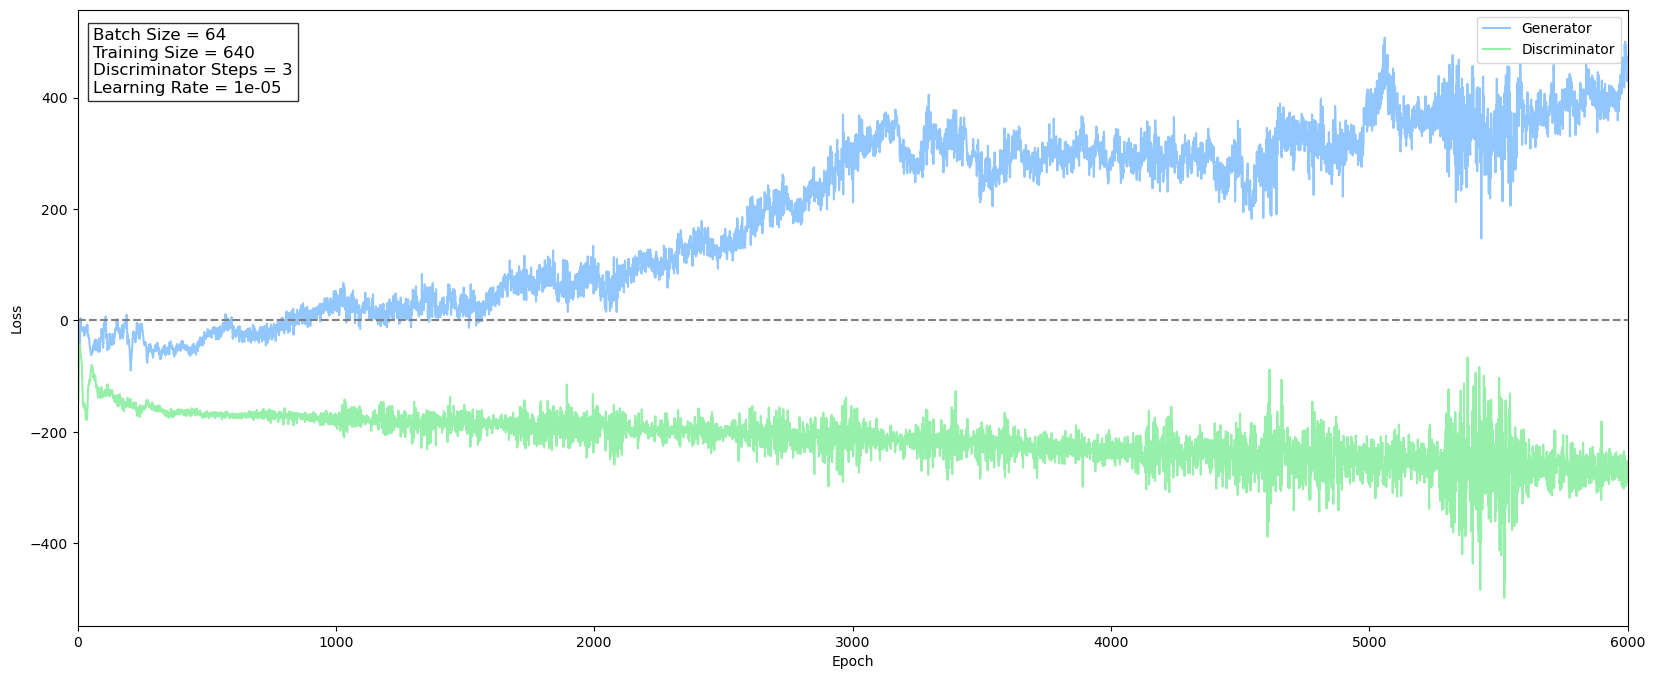

In [54]:
plt.style.use('seaborn-pastel')
plt.figure(figsize=(20,8))
plt.plot(g_loss, label = "Generator")
plt.plot(d_loss, label = "Discriminator")
plt.legend()
plt.xlim(0,specs["Epochs"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axhline(y=0, color = "grey", linestyle = "dashed")

plt.text(0.01, 0.97, specs_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

fig_dir = f"{model_directory}/loss_graph.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()


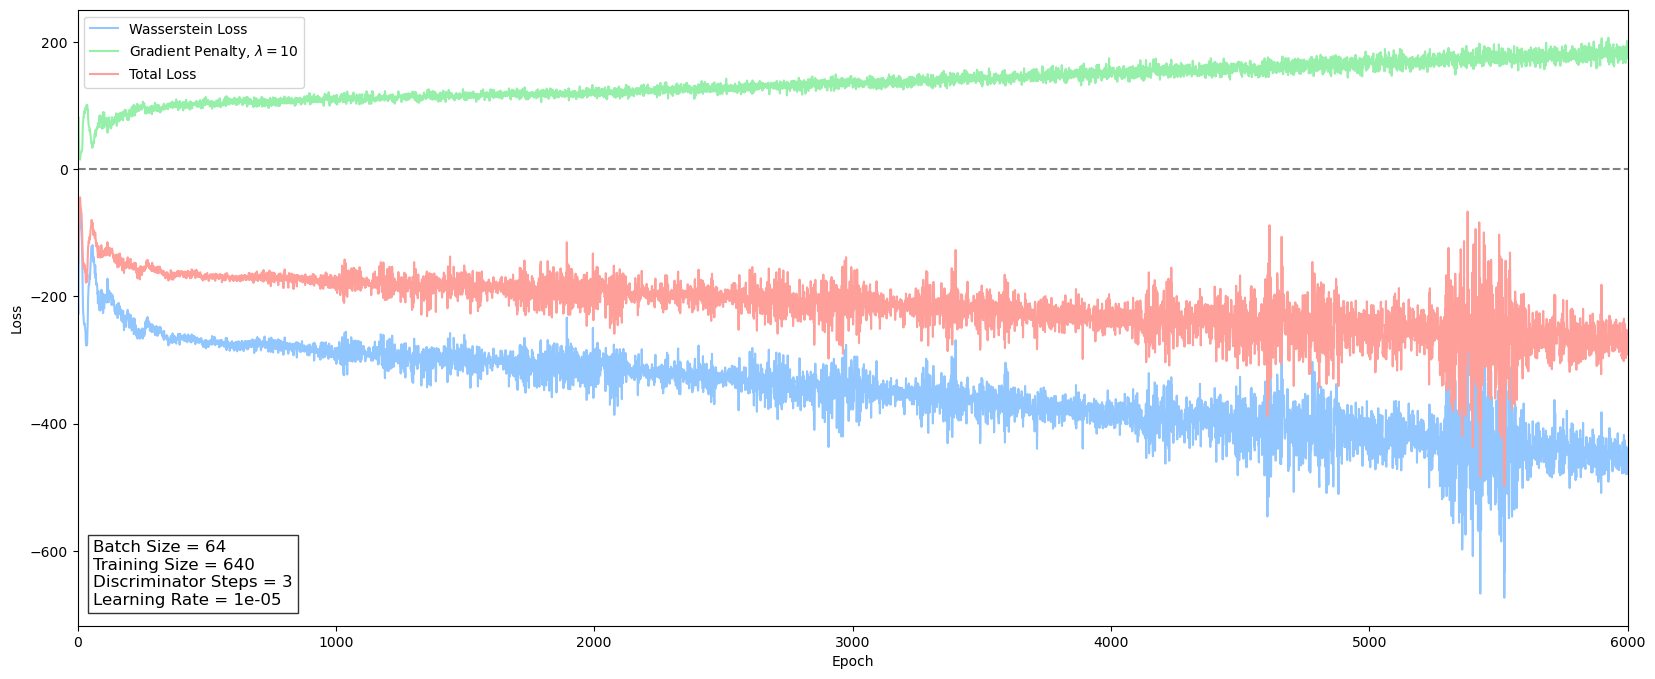

In [55]:
gp_weight = specs["GP Weight"]
plt.figure(figsize=(20,8))
plt.plot(d_w_loss, label = "Wasserstein Loss")
plt.plot(np.array(d_gp)*gp_weight, label = f"Gradient Penalty, $\lambda = {gp_weight}$")
plt.plot(d_loss, label = "Total Loss")
plt.legend()
plt.xlim(0,specs["Epochs"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axhline(y=0, color = "grey", linestyle = "dashed")

plt.text(0.01, 0.03, specs_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

fig_dir = f"{model_directory}/discriminator_loss_graph.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()